In [118]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.font_manager import FontProperties

%matplotlib inline

# RIXS data prep

At SLAC, we collected RIXS on platinum halide single crystal samples. These materials are organometallic, meaning they are susceptible to damage due to exposure to the X-ray beam. we needed to balance that with the objective of collecting as much high quality data. When at a beamline, your time is limited and our sample quantity was limited as well. The decision was to take 2 full scans on a single spot on the sample, then translate the the beam spot to an unexposed spot on the sample and run another 2 scans, etc. The 2 scans for each spot need to be kept seperate at least initially since the conditions of the scans are different. We need to see if we can detect a difference between the unexposed first cans on each spot and the 2nd scans for each spot. Along with these two scans, a third t=1 second long scan was collected for normalization purposes.

## 1.a) Extracting raw data from SLAC beamline

The data from SLAC is in a large single txt file with nested headers. The first step to analyzing the data is to properly pull the data from this large txt file. The top header with some relevant info about the entire set of data is saved in a header* file. The remaining data is split between the 2 scans of each spot on the crystal exposed to the beam followed by the time scan. These 3 sets of data are seperated into individual data files.

splitting these data files also gives us the opportunity to to build a pandas dataframe in preperation to subsequent steps in this process

In [33]:
#create integer tuple for use in grabbing relevant lines of the data file
l1=[]
for x in list(range(0,10,1)):
    l1.append(str(x))
num=tuple(l1)

#import data file and open intial header file to exported to.
f1=open('PtI_Par_3.txt','r')
f2=open(f'PtI_Par_3_raw_data/header_PtI_Par_3.txt','w+')

#initialize index counters used to divide the data into 1st and 2nd scans and time scan

i=0
l=0
m=0
n=0

#header logical flag
header=0

#make sure the pointer is at the start of the file
f1.seek(0)

#grab line from datafile
for x in f1:
    
    #some of the lines are empty, need to skip them in the loop
    if x=='\n':
        #print('empty')
        continue
    else: 
        
        #creating the initial header file that has diagnostic info on the beamline and crystal orientation
        if header==0:
            if x.strip().startswith('#N')==True:
                f2.write(x.strip())
                f2.write('\n')
                header=1
            elif x.strip().startswith('#')==True:
                f2.write(x.strip())
                f2.write('\n')
        
        #split the data into seperate files for each scan           
        elif header==1:
            if x.strip().startswith('#L')==True:
                
                #file name changer, each preceding file is closed and a new file is opened
                if i%3==0:
                    m+=1
                    f2.close()
                    f2=open(f'PtI_Par_3_raw_data/PtI_Par_3_1_{m}_r.csv','w+')
                    f2.write(x.strip().replace('#L ','').replace('  ',','))
                    f2.write('\n')
                elif i%3==1:
                    n+=1
                    f2.close()
                    f2=open(f'PtI_Par_3_raw_data/PtI_Par_3_2_{n}_r.csv','w+')
                    f2.write(x.strip().replace('#L ','').replace('  ',','))
                    f2.write('\n')
                elif i%3==2:
                    l+=1
                    f2.close()
                    f2=open(f'PtI_Par_3_raw_data/PtI_Par_3_t_{l}_r.csv','w+')
                    f2.write(x.strip().replace('#L ','').replace('  ',','))
                    f2.write('\n')
                
                i+=1
                
            #grabs the numerical data and puts it into current open f2 file as decided by above conditionals    
            elif x.strip().startswith(num)==True:
                f2.write(x.strip().replace(' ',','))
                f2.write('\n')
                continue
# close files            
f1.close()
f2.close()

## 1.b) Concentration file

along with the data scans, we also have a set of concentration scans that are used to normalize the data. concentration scans are done once for each of the three data scans performed above. The strucutre of the txt file is similar to the data files so we can use the same set of code without the conditional file name change section.

In [35]:
#create integer tuple for use in grabbing relevant lines of the data file
l1=[]
for x in list(range(0,10,1)):
    l1.append(str(x))
num=tuple(l1)

#import concentration file and open intial header file to exported to.
f1=open('PtI_Par_3_Concentration.txt','r')
f2=open('PtI_Par_3_concentration/header_PtI_Par_3_c.txt','w+')

#initialize index counters used to divide the data into 1st and 2nd scans and time scan
i=0

#header logical flag
header=0

#make sure the pointer is at the start of the file
f1.seek(0)

#grab line from datafile
for x in f1:
    
    #some of the lines are empty, need to skip them in the loop
    if x=='\n':
        #print('empty')
        continue
    else: 
        
        #creating the initial header file that has diagnostic info on the beamline and crystal orientation
        if header==0:
            if x.strip().startswith('#N')==True:
                f2.write(x.strip())
                f2.write('\n')
                header=1
            elif x.strip().startswith('#')==True:
                f2.write(x.strip())
                f2.write('\n')
        
        #split the data into seperate files for each scan           
        elif header==1:
            if x.strip().startswith('#L')==True:
                
                #file name changer, each preceding file is closed and a new file is opened
                i+=1
                f2.close()
                f2=open(f'PtI_Par_3_concentration/PtI_Par_3_1_{i}_c.csv','w+')
                f2.write(x.strip().replace('#L ','').replace('  ',','))
                f2.write('\n')
                
            #grabs the numerical data and puts it into current open f2 file as decided by above conditionals    
            elif x.strip().startswith(num)==True:
                f2.write(x.strip().replace(' ',','))
                f2.write('\n')
                continue
# close files            
f1.close()
f2.close()

## 2.a) Processing: raw data to cooked data

You start with raw data in physics. Raw counts from a spectremeter, a scintilator, a diode, whatever. Those numbers rarely give the result we are interested in, or at least in a form that is understandable. We need to go through a set of processes and normalizations to make the data presentable. What needs to be done varies depending on what data was collected and what physics is involved. This whole process of taking raw data and making it ready for study is, at least in my group, called cooking the data.  

There is some preliminary processing that does not depend on the physics. The first one I'll be doing is rebinning the data. When X-ray spectroscopy data is collected, we want to see the absorption of the photons as a function of the energy being impinged on the sample. Synchrotrons that are used to create X-rays for experiments produce them in a wide range of energies. The synchrotron has multiple (as many as 20 or 30) different research groups all using these different energy x-rays at the same time. The way each team gets the energy they want is by using a monochromator. These X-ray monochromators are often giant sheets of material that when X-rays hit them, only a certain energy is reflected. What energy is reflected depends on what angle the x-rays hit the monochromator at. When we used the monochromator at SLAC we had it moving over a 150eV range around 11.5 kev 71 times. Throughout each of these scans we could hear the large motors moving these sheets and when we got to the end of each scan, the collection had to pause while the monochromator realigned back to the beginning angle again. This explanation is all to setup why rebinning is necessary. If you look at any of the raw data you can see what the monochromator energies were for each datapoint. We set them to regular intervals, you can see that the actual values varied very slightly, this is due to the large moving sheets settling slighty off from they should be. Everything is very accuate, the motors can stop on a dime, but even a dime has a width. So I'll go through each file and move the energy to what it should be. 

Thankfully when I created the raw data files I formated them to be csv files so I can effortlessly switch into pandas DataFrame to work with the data from here.

In [219]:
i=1
j=1
while j <=2:

    while i<=71:
        reg=[]
        df=pd.read_csv(f'PtI_Par_3_raw_data/PtI_Par_3_{j}_{i}_r.csv')

        for x in df['mono'].iteritems():
            numba=math.modf(x[1])
            reg.append(numba[1]+(round(numba[0]*100)/100))
        df.insert(loc=0,column='MONO',value=reg)
        del df['mono']
        df.to_csv(f'PtI_Par_3_cooked_data/PtI_Par_3_{j}_{i}_p.csv',index=False)
        i+=1
    i=1
    j+=1


## 2.b) Calibration

we now have rebinned clean MONO data. But we now need to calibrate it. Due to the instrumentation not being ideal (and it never will be) the reported energies can drift by an eV or more over the course of a run. This would make it difficult to compare scans to each other during a run, or compare data between runs. So before any data is collected on samples we are interested in, we collect a scan on a simple pure elemental sample, in this case, a Pt foil. With that sample we look at the I0 channel. This is the X-ray beam before it interacts with anything. We then look for large dips in  the I0. These are called 'Bragg peaks' the same physics that allows the large slabs of silicon to select the energy we want also creates these large dips in I0 signal. They appear no matter what sample is collected on. If we take note of where it appears we can calibrate the x-axis of all of our scans off of where the I0 Bragg peak appears. 

Thats why we collected data at that high region at all, because a large bragg peak appeared there. 

The calibration value, the location of the Bragg peak for our Pt foil sample was 11701.9eV

using the first scan we can look at I0

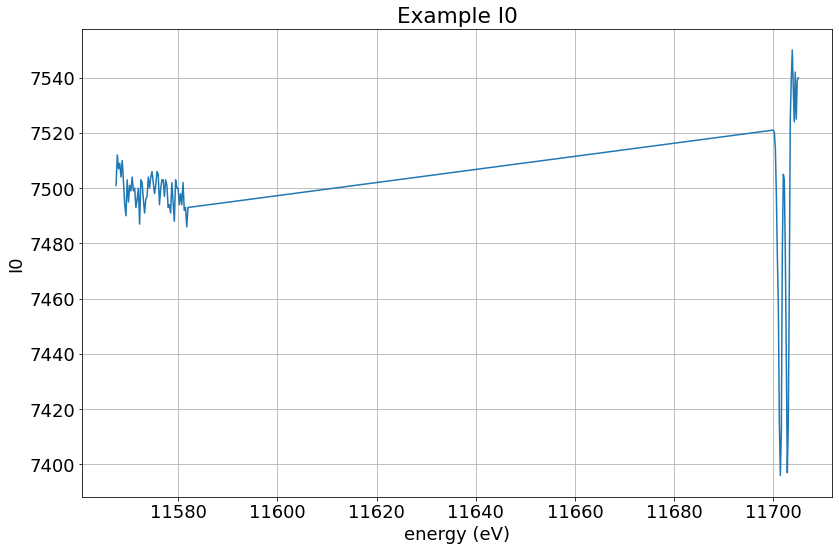

In [185]:
df=pd.read_csv(f'PtI_Par_3_cooked_data/PtI_Par_3_1_1_p.csv')

font={'size':18}

matplotlib.rc('font',**font)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(df['MONO'],df['I0'])

ax.set_title('Example I0')
ax.set_ylabel('I0')
ax.set_xlabel('energy (eV)')
#ax.set_xlim(0,101)
#ax.set_ylim(0,410)
ax.xaxis.grid()
ax.yaxis.grid()

plt.tight_layout()

The region we are interested in is on the left around 11560 eV where as the region we collected for the glitch is around 11700 eV. We can see that if differs by .1eV. that may not seem large but it is important to account for it when the features we will be eventually look at are only an eV wide.

In [190]:
df=pd.read_csv(f'PtI_Par_3_cooked_data/PtI_Par_3_1_1_p.csv')
scanmin=df.loc[df['I0']==df['I0'].min()]['MONO']
print(scanmin)

66    11701.4
Name: MONO, dtype: float64


In [248]:
localmin=11701.9
i=1
j=1
while j <=2:

    while i<=71:
        calib=[]
        
        df=pd.read_csv(f'PtI_Par_3_cooked_data/PtI_Par_3_{j}_{i}_p.csv')
        scanmin=df.loc[df['I0']==df['I0'].min()]['MONO'].values
        shift=localmin-scanmin[0]
        
        for x in df['MONO'].iteritems():
            y=x[1]
            y=x[1]+shift
            calib.append(float(y))
            
        df.insert(loc=1, column='Calibrated', value=calib)
        df=df.assign(SHIFT=float(shift))
        df.to_csv(f'PtI_Par_3_cooked_data/PtI_Par_3_{j}_{i}_p.csv',index=False)
        i+=1
    j+=1

1 11701.4
2 11701.4
3 11702.8
4 11701.4
5 11701.4
6 11701.4
7 11701.6
8 11701.6
9 11569.25
10 11701.6
11 11701.6
12 11701.6
13 11701.6
14 11567.5
15 11701.6
16 11701.4
17 11701.6
18 11701.6
19 11701.6
20 11701.6
21 11701.8
22 11701.8
23 11703.2
24 11701.8
25 11701.8
26 11703.2
27 11703.2
28 11701.6
29 11701.8
30 11703.2
31 11701.8
32 11703.2
33 11701.8
34 11570.0
35 11701.8
36 11701.8
37 11701.8
38 11701.8
39 11562.0
40 11701.8
41 11701.8
42 11701.8
43 11701.8
44 11560.25
45 11701.8
46 11701.8
47 11702.0
48 11701.8
49 11557.75
50 11701.8
51 11701.8
52 11701.8
53 11701.8
54 11556.25
55 11701.8
56 11701.8
57 11701.8
58 11701.8
59 11558.25
60 11701.8
61 11701.8
62 11702.0
63 11701.8
64 11558.25
65 11701.8
66 11701.8
67 11701.8
68 11701.8
69 11551.5
70 11701.8
71 11701.8
